In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import glob
from scipy.stats import zscore
from plotnine import *
import json
import statistics
#import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats import ttest_ind,ranksums
#import patchworklib as pw
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from mizani.formatters import percent_format
from scipy.stats import chi2,chi2_contingency

In [5]:
sample_info = pd.read_csv('sample_info_addedfeatures_v7.csv',sep='\t')

In [6]:
X = sample_info.iloc[:,:-1]
y = sample_info.cancer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=X['Tumor type'])

# Background

Paper: The size of cell-free mitochondrial DNA in blood is inversely correlated with tumor burden in cancer patients

Qin An1, Youjin Hu1, Qingjiao Li2,Xufeng Chen2,3, Jiaoti Huang2,3, Matteo Pellegrini4, Xianghong Jasmine Zhou2, Matthew Rettig5 and Guoping Fan1,

<img src="mt_img.PNG" width="500">

#### 1. mtDNA fragments are shorter than fragments from the nuclear genome
#### 2. mtDNA fragments from cancer patients are shorter than from healthy patients

#### 3. mtDNA copy number

# EDA

### 1. Fragment Size Metrics across Chromosomes for Cancer vs Normal

In [7]:
df_list = []
for i in range(0,25,1):
    with open('overall_medians_means.txt', 'r') as infile:
        lines = [line.strip() for line in infile][i*11:(i*11)+11]
        chrom = lines[0]
        
        normal_median = float(lines[3].split(':')[1])
        cancer_median = float(lines[4].split(':')[1])
        
        normal_mean = float(lines[6].split(':')[1])
        cancer_mean = float(lines[7].split(':')[1])
        
        normal_stdev = float(lines[9].split(':')[1])
        cancer_stdev = float(lines[10].split(':')[1])
        
        row_list = [chrom,normal_median,cancer_median,normal_mean,cancer_mean,normal_stdev,cancer_stdev]
        df_list.append(row_list)

In [8]:
pd.DataFrame(df_list,columns=['chrom','normal_median','cancer_median','normal_mean','cancer_mean','normal_stdev','cancer_stdev'])

chrom  normal_median  cancer_median  normal_mean  cancer_mean  \
0      1          167.0          166.0   173.069867   174.391483   
1      2          167.0          167.0   173.881600   174.440000   
2      3          168.0          167.0   173.814267   175.101207   
3      4          167.0          167.0   172.694267   174.823138   
4      5          168.0          167.0   172.827200   175.058379   
5      6          167.0          167.0   173.214133   174.938655   
6      7          168.0          167.0   173.673600   174.599069   
7      8          167.0          166.0   172.663467   174.483586   
8      9          167.0          167.0   172.046800   174.464207   
9     10          167.0          167.0   173.074667   175.065724   
10    11          167.0          167.0   172.899600   175.464034   
11    12          167.0          166.0   174.338267   174.644862   
12    13          167.0          166.0   172.300667   173.931759   
13    14          167.5          167.0   173.298533   174.944379   
14    15          167.0          167.0   174.277600   175.185621   
15    16          167.0          167.0   172.687200   174.681379   
16    17          168.0          166.0   174.524267   175.798483   
17    18          168.0          166.0   173.297067   174.629793   
18    19          166.0          166.0   173.204133   175.202345   
19    20          167.0          167.0   172.795600   175.376862   
20    21          167.0          166.0   173.782000   174.779000   
21    22          167.0          166.0   174.085333   175.936310   
22     X          167.0          166.0   171.989733   174.030828   
23     Y          165.0          164.0   164.512400   165.087552   
24    MT          143.0          153.0   160.863067   173.413431   

    normal_stdev  cancer_stdev  
0      44.541874     48.330206  
1      44.914933     47.671439  
2      44.302630     48.468489  
3      43.301724     48.268458  
4      43.744515     48.453041  
5      44.869002     48.060912  
6      45.380399     48.043833  
7      42.646052     47.852018  
8      44.011152     47.835868  
9      44.495015     48.903247  
10     44.518951     49.174436  
11     45.128010     48.583477  
12     42.440179     47.091245  
13     43.682550     49.002270  
14     45.662941     48.672418  
15     44.036151     48.160631  
16     47.357395     50.421582  
17     43.913009     48.087336  
18     47.322913     50.315871  
19     43.633986     49.740736  
20     45.405151     48.590644  
21     45.284629     50.375551  
22     41.363886     46.920689  
23     36.447076     39.713107  
24     72.739166     74.035695

#### 2. Fragment Size of Mitochondrial DNA

In [9]:
#adding the label back for EDA
X_train['Cancer'] = y_train

In [13]:
cancer_medians = list(X_train[X_train.Cancer == 1].mt_median_fragsize)
normal_medians = list(X_train[X_train.Cancer == 0].mt_median_fragsize)

In [16]:
with open('../cancer_medians.txt','w') as f:
    for i in cancer_medians:
        f.write(str(i) + '\n')

In [17]:
with open('../normal_medians.txt','w') as f:
    for i in normal_medians:
        f.write(str(i) + '\n')

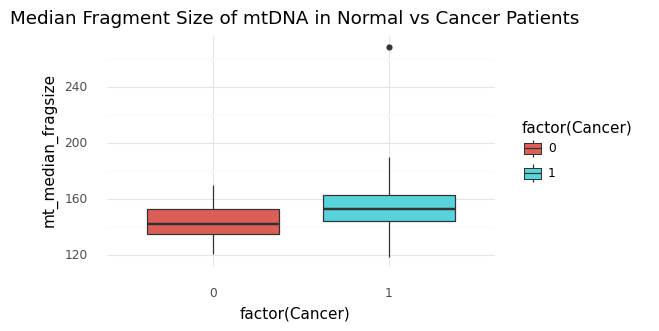

<ggplot: (8783494028825)>

In [9]:
ggplot(X_train) + aes(x='factor(Cancer)',y='mt_median_fragsize',fill='factor(Cancer)') + geom_boxplot() + \
theme_minimal() + theme(figure_size=(5,3)) + labs(title = 'Median Fragment Size of mtDNA in Normal vs Cancer Patients')

In [36]:
fifteen_cancer_samples = list(X_train[X_train.Cancer == 1].iloc[0:15]['CPM.UID'])
fifteen_normal_samples = list(X_train[X_train.Cancer != 1].iloc[0:15]['CPM.UID'])

In [41]:
fifteen_normal_dict = {}
fifteen_cancer_dict = {}

for sample in fifteen_normal_samples:
    json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
    f = open(json_loc)
    json_dict = json.load(f)
    frag_sizes = json_dict['MT']
    fifteen_normal_dict[sample] = frag_sizes
    
for sample in fifteen_cancer_samples:
    json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
    f = open(json_loc)
    json_dict = json.load(f)
    frag_sizes = json_dict['MT']
    fifteen_cancer_dict[sample] = frag_sizes

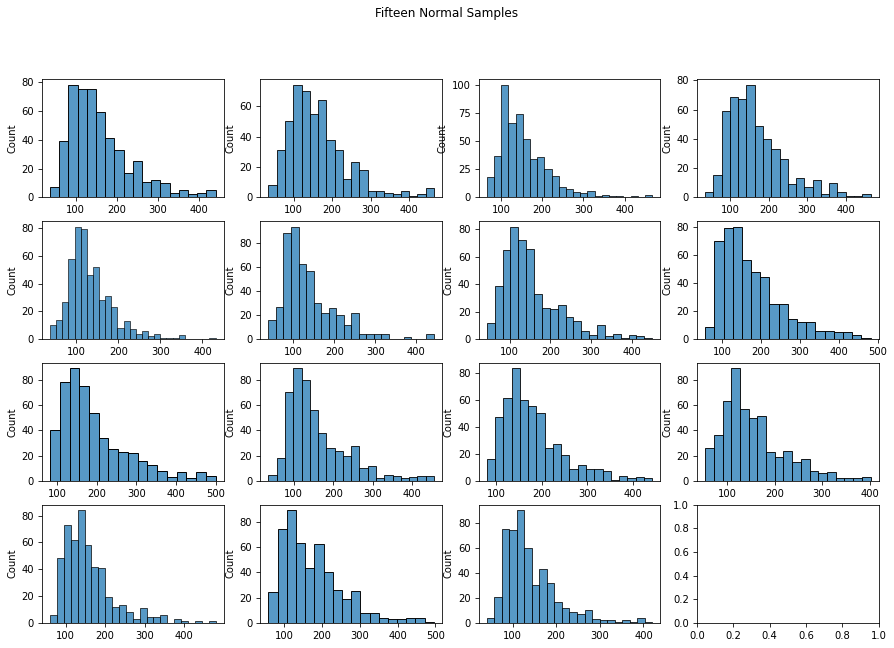

In [51]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
fig.suptitle('Fifteen Normal Samples')

sample_counter = 0

for i in range(0,4):
    for j in range(0,4):
        sns.histplot(ax=axes[i, j], x=fifteen_normal_dict[fifteen_normal_samples[sample_counter]])
        
        if(sample_counter < len(samples)-1):
            sample_counter+=1
        else:
            break

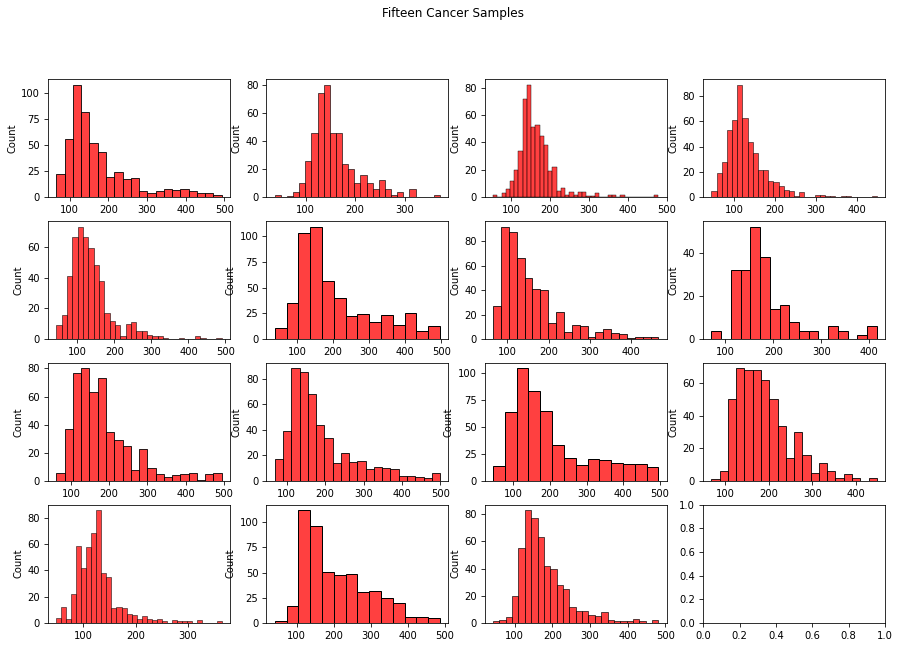

In [52]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
fig.suptitle('Fifteen Cancer Samples')

sample_counter = 0

for i in range(0,4):
    for j in range(0,4):
        sns.histplot(ax=axes[i, j], x=fifteen_cancer_dict[fifteen_cancer_samples[sample_counter]],color='red')
        
        if(sample_counter < len(samples)-1):
            sample_counter+=1
        else:
            break
        
    

In [75]:
control_samples = list(X_train[X_train['Tumor type'] == 'Control']['CPM.UID'])
cancer_samples = list(X_train[X_train['Tumor type'] != 'Control']['CPM.UID'])

In [76]:
def compare_dists(chrom):
    control_frag_sizes = []
    for sample in control_samples:
        json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
        f = open(json_loc)
        json_dict = json.load(f)
        control_frag_sizes = control_frag_sizes + json_dict[chrom]

    cancer_frag_sizes = []
    for sample in cancer_samples:
        json_loc = glob.glob('../fragsize_jsons/*'+sample+'*')[0]
        f = open(json_loc)
        json_dict = json.load(f)
        cancer_frag_sizes = cancer_frag_sizes + json_dict[chrom]
    
    p1 = ggplot() + aes(x=control_frag_sizes) + geom_histogram() + theme_minimal() + theme(figure_size = (5,3)) + labs(title = f'Normal Fragment Sizes for {chrom}')
    p2 = ggplot() + aes(x=cancer_frag_sizes) + geom_histogram() + theme_minimal() + theme(figure_size = (5,3)) + labs(title = f'Cancer Fragment Sizes for {chrom}')
    
    g1 = pw.load_ggplot(p1, figsize=(3,3))
    g2 = pw.load_ggplot(p2, figsize=(3,3))
    
    #return [g1,g2]
    return [control_frag_sizes,cancer_frag_sizes]

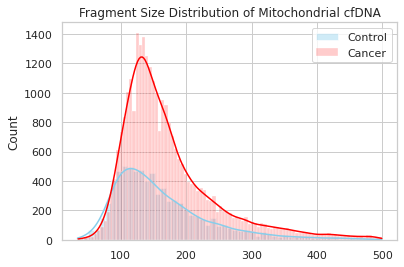

In [77]:
controls,cancers = compare_dists('MT')

sns.set(style="whitegrid")

sns.histplot(x=controls, color="skyblue", label="Control", kde=True, alpha=0.4)
sns.histplot(x=cancers, color="red", label="Cancer", kde=True, alpha=0.2)

plt.title('Fragment Size Distribution of Mitochondrial cfDNA')
plt.legend() 
plt.show()

#### 3. Mitochondrial Copy Number

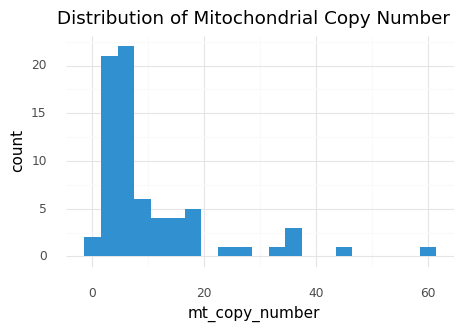

<ggplot: (8793314364377)>

In [78]:
ggplot(X_train[X_train['mt_copy_number'] < 100]) + aes(x='mt_copy_number') + \
geom_histogram(bins=20,binwidth=3,fill='#3191D0') + labs(title='Distribution of Mitochondrial Copy Number') \
+ theme_minimal() + theme(figure_size=(5,3))

##### Looked at mitochondrial copy number for cancer vs cancer. Difference is non-significant by a t-test. 

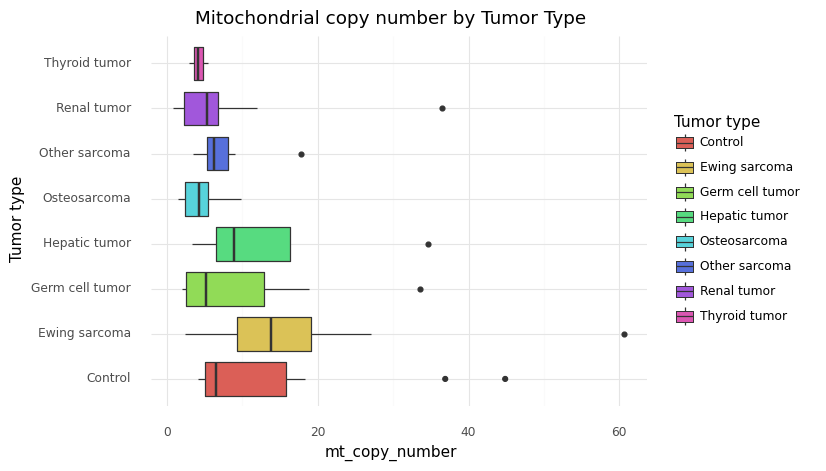

<ggplot: (8793314213114)>

In [85]:
ggplot(X_train[X_train['mt_copy_number'] < 100]) + aes(x='Tumor type',y='mt_copy_number',fill='Tumor type') + \
geom_boxplot() + coord_flip() + labs(title = 'Mitochondrial copy number by Tumor Type') + theme_minimal()

In [80]:
osteosarcoma_copy_numbers = list(X_train[X_train['Tumor type'] == 'Osteosarcoma'].mt_copy_number)
other_sarcoma_copy_numbers = list(X_train[X_train['Tumor type'] == 'Other sarcoma'].mt_copy_number)
ewing_sarcoma_copy_numbers = list(X_train[X_train['Tumor type'] == 'Ewing sarcoma'].mt_copy_number)
control_copy_numbers = list(X_train[X_train['mt_copy_number'] < 100][X_train['Tumor type'] == 'Control'].mt_copy_number)

Here we seem to see a difference between osteosarcoma mt_copy_number and control. However, the sample size for each group is 16 and 14, and variances are quite different. Therefore, I am uncertain about which test to use. TBD.

In [81]:
ttest_ind(control_copy_numbers,osteosarcoma_copy_numbers,equal_var=False)

Ttest_indResult(statistic=2.585206808865785, pvalue=0.021785682405494413)

In [82]:
ranksums(control_copy_numbers,osteosarcoma_copy_numbers)

RanksumsResult(statistic=3.0346501252184708, pvalue=0.0024081487135270752)

Here we look at the outliers i.e. mitochondrial copy number is higher than 30. We will look for mutational patterns in these samples. 

In [11]:
outliers = list(X_train[X_train['mt_copy_number']>30]['CPM.UID'])

In [13]:
with open('mt_copynumber_outliers.txt','w') as f:
    for sample in outliers:
        f.write(sample+'\n')

#### 4. ichorCNA Missed Samples

In [83]:
ichor_missed = X_train[X_train['CMA_abnormal'] != X_train['Cancer']]

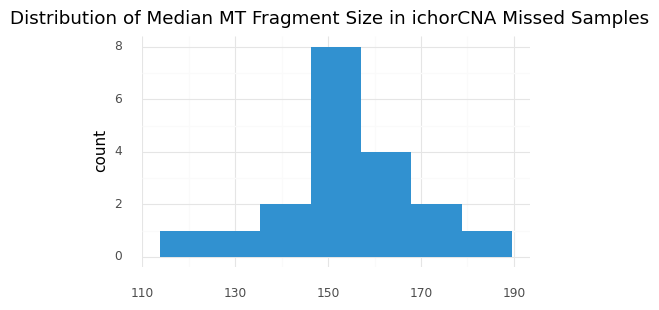

<ggplot: (8793314552453)>

In [84]:
ggplot() + aes(x=list(ichor_missed['mt_median_fragsize'])) + geom_histogram(fill='#3191D0') + \
theme_minimal() + theme(figure_size=(5,3)) + labs(title = 'Distribution of Median MT Fragment Size in ichorCNA Missed Samples')

In [35]:
ichor_missed['mt_median_fragsize'].mean()

153.42105263157896

In [41]:
ichor_missed['Tumor type'].value_counts()

Ewing sarcoma      5
Germ cell tumor    4
Osteosarcoma       3
Renal tumor        3
Thyroid tumor      2
Hepatic tumor      1
Other sarcoma      1
Name: Tumor type, dtype: int64

In [47]:
ichor_missed['Timepoint'].value_counts()

At relapse      7
On therapy      6
At diagnosis    6
Name: Timepoint, dtype: int64

In [49]:
ichor_missed['Localized.Metastatic'].value_counts()

Metastatic    10
Localized      9
Name: Localized.Metastatic, dtype: int64

In [50]:
ichor_missed['Sex'].value_counts()

F    11
M     8
Name: Sex, dtype: int64

Based on these value counts, it doesn't seem like there are any patterns in the types of samples that ichorCNA is failing to call as cancer.

In [102]:
ichor_preds = list(sample_info['ichor_profile_result'])
labels = list(sample_info['cancer'])

In [103]:
matches = sample_info[sample_info['ichor_profile_result'] == sample_info['cancer']]
true_positives = len(matches[matches['cancer']==1])
true_negatives = len(matches[matches['cancer']==0])

mismatches = sample_info[sample_info['ichor_profile_result'] != sample_info['cancer']]
false_positives = len(mismatches[mismatches['cancer']==0])
false_negatives = len(mismatches[mismatches['cancer']==1])

In [114]:
print(f'Precision of ichorCNA predictions:{round(metrics.precision_score(labels,ichor_preds),3)}')

Precision of ichorCNA predictions:0.93


In [115]:
print(f'Recall of ichorCNA predictions:{round(metrics.recall_score(labels,ichor_preds),3)}')

Recall of ichorCNA predictions:0.548


#### 5. Timepoint Analysis

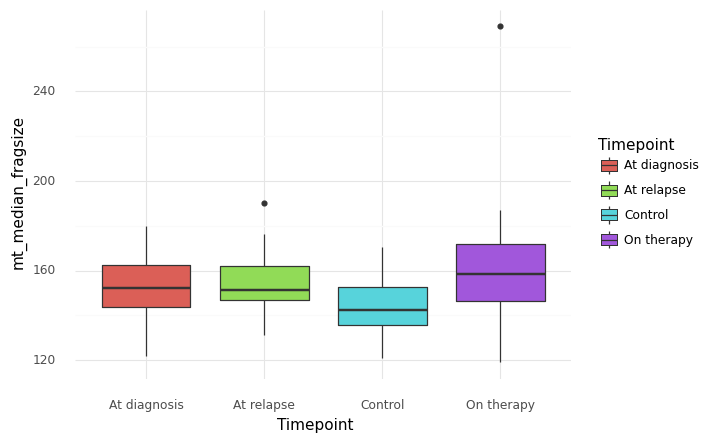

<ggplot: (8793358377994)>

In [120]:
ggplot(X_train) + aes(x='Timepoint',y='mt_median_fragsize',fill='Timepoint') + geom_boxplot() + theme_minimal()

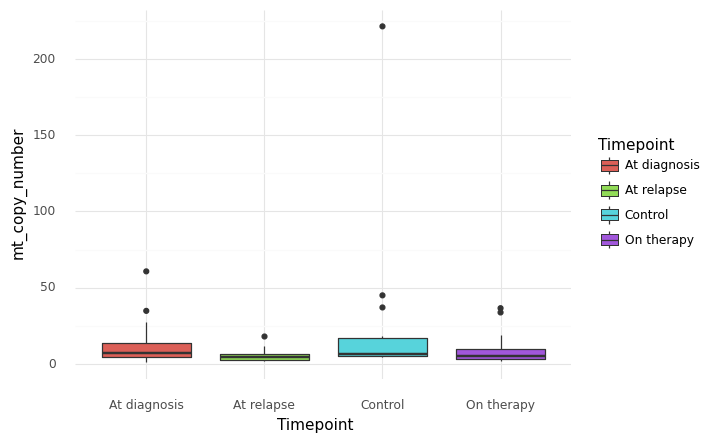

<ggplot: (8793314585308)>

In [122]:
ggplot(X_train) + aes(x='Timepoint',y='mt_copy_number',fill='Timepoint') + geom_boxplot() + theme_minimal()

Below I see how many samples there are in the test set where ichorCNA prediction is wrong. 

In [142]:
X_test['Cancer'] = y_test

In [144]:
X_test[X_test['ichor_profile_result'] != X_test['Cancer']]

Sample ID      CPM.UID   Current.Label  \
38  CPM00021541-PL-D-20211105_20211202  CPM00021541      ctDNA-3N-4   
69  CPM00022119-PL-D-20210910_20220302  CPM00022119  ctDNA-9N-7 (R)   
21  CPM00020143-PL-D-20210910_20211129  CPM00020143     ctDNA-2N-10   
44  CPM00019339-PL-D-20210709_20211129  CPM00019339      ctDNA-5N-4   
13  CPM00021797-PL-D-20211207_20220119  CPM00021797     ctDNA-1R1-4   
8   CPM00021296-PL-D-20211020_20211129  CPM00021296      ctDNA-1N-9   

    Date.drawn            Baseline.sample.Relapse     Timepoint CMA available  \
38   11/5/2021                    True baseline ü  At diagnosis           YES   
69   9/10/2021    Post Surgery/Pre Chemo Baseline    On therapy            NO   
21   9/10/2021                    Baseline/Pre C2    On therapy           YES   
44    7/9/2021  Pre Chemo/Post Surgery Baseline ü    On therapy           YES   
13   12/7/2021              True Baseline Relapse    At relapse            NO   
8   10/20/2021                     True Baseline   At diagnosis           YES   

         CMA result   Profile.result Stage At Diagnosis  ... 20_mean_fragsize  \
38         Abnormal  Non-informative         Metastatic  ...       176.062000   
69              NaN  Non-informative          Localized  ...       177.760000   
21  Non-informative  Non-informative         Metastatic  ...       178.939638   
44         Abnormal  Non-informative          Localized  ...       172.160000   
13              NaN  Non-informative          Localized  ...       178.762000   
8   Non-informative  Non-informative          Localized  ...       176.326000   

   21_mean_fragsize 22_mean_fragsize X_mean_fragsize Y_mean_fragsize  \
38       176.456000       179.066000      174.732000      162.936000   
69       177.678000       174.562000      174.568000      169.034000   
21       177.994831       179.304739      177.131186      166.788943   
44       169.864000       170.822000      167.864000      158.462000   
13       176.120000       177.380000      177.568000      171.784000   
8        176.234000       176.618000      175.926000      161.962000   

   MT_mean_fragsize CMA_abnormal mt_median_fragsize ichor_profile_result  \
38       178.876000            1              155.0                    0   
69       191.470588            0              176.0                    0   
21       164.745665            0              160.0                    0   
44       187.540000            1              162.0                    0   
13       187.684000            0              161.5                    0   
8        153.770000            0              139.0                    0   

   Cancer  
38      1  
69      1  
21      1  
44      1  
13      1  
8       1  

[6 rows x 78 columns]

#### 6. Multivariate Analysis

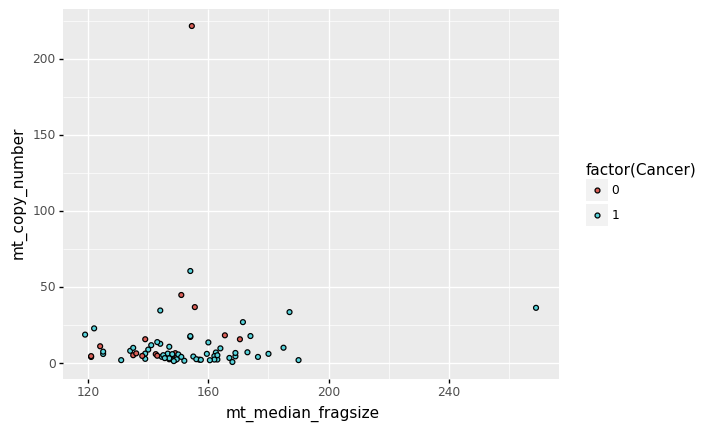

<ggplot: (8783493848031)>

In [13]:
ggplot(X_train) + aes(x='mt_median_fragsize',y='mt_copy_number',fill='factor(Cancer)') + geom_point()

#### 7. Mutation Analysis

In [4]:
mut_eda_df = X_train.iloc[:,52:]
cols = mut_eda_df.columns
cols = list(cols[1:]) + list(cols[:1])
mut_eda_df = mut_eda_df[cols]

In [5]:
selector = VarianceThreshold(threshold = 0.2)

In [6]:
selector.fit_transform(mut_eda_df).shape

(73, 31)

In [7]:
selector.get_feature_names_out()

array(['16444.C>T', '16355.C>T', '16496.G>A', '263.A>G', '15326.A>G',
       '16311.T>C', '16230.A>G', '16301.C>T', '16274.G>A', '13105.A>G',
       '16368.T>C', '16278.C>T', '14766.C>T', '16399.A>G', '13095.T>C',
       '16129.G>A', '16527.C>T', '16249.T>C', '1438.A>G', '2706.A>G',
       '16519.T>C', '16356.T>C', '16390.G>A', '12684.G>A', '16218.C>T',
       '12705.C>T', '11719.G>A', '310.T>C', '750.A>G', '16223.C>T',
       '73.A>G'], dtype=object)

In [15]:
def create_mut_plot(mut):
    temp_mut_eda_df = mut_eda_df[[mut,'cancer']]
    temp_df = temp_mut_eda_df.groupby(temp_mut_eda_df[mut]).value_counts(normalize=True).rename('Proportion').reset_index()
    p1 = temp_df.pipe((sns.barplot,'data'),x=mut,y='Proportion',hue='cancer')
    return p1

In [20]:
interesting_muts = []
p_values = {}
for mut in mut_eda_df.columns[:-1]:
    cont_table = pd.crosstab(mut_eda_df[mut],mut_eda_df['cancer'])
    result = chi2_contingency(cont_table)
    if(result[1]<0.05):
        interesting_muts.append(mut)
        p_values[mut] = result[1]

In [21]:
for mut in interesting_muts:
    print(pd.crosstab(mut_eda_df[mut],mut_eda_df['cancer']))
    print(f'P-value:{p_values[mut]}')
    print('----------------------------')

cancer      0   1
16355.C>T        
0.0        12  26
1.0         3  32
P-value:0.03230661444504172
----------------------------
cancer      0   1
16311.T>C        
0.0        13  29
1.0         2  29
P-value:0.023338211358141507
----------------------------
cancer      0   1
16368.T>C        
0.0        12  26
1.0         3  32
P-value:0.03230661444504172
----------------------------
cancer      0   1
16129.G>A        
0.0        14  30
1.0         1  28
P-value:0.008301979908125845
----------------------------
cancer      0   1
16390.G>A        
0.0        12  27
1.0         3  31
P-value:0.042918709319231
----------------------------


<AxesSubplot:xlabel='16129.G>A', ylabel='Proportion'>

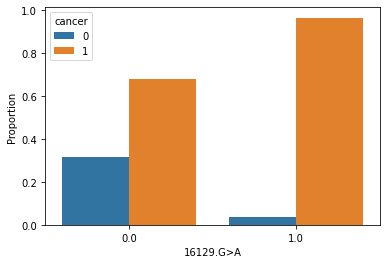

In [22]:
create_mut_plot('16129.G>A')

In [23]:
interesting_muts

['16355.C>T', '16311.T>C', '16368.T>C', '16129.G>A', '16390.G>A']